In [751]:
import math

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

In [752]:
train = pd.read_csv("train_weather.csv")
test = pd.read_csv("test_weather.csv")

In [753]:
# make copies of origin dataset
train_original=train.copy()
test_original=test.copy()

In [754]:
train_original.shape, test_original.shape

((14006, 45), (3504, 44))

In [755]:
train_original.head(), test_original.head()

(   id           date  speed  around_holiday  holiday  temperature  \
 0   0  1/1/2017 0:00  43.00           False     True        18.07   
 1   1  1/1/2017 1:00  46.12           False     True        17.82   
 2   2  1/1/2017 2:00  44.29           False     True        17.89   
 3   3  1/1/2017 3:00  41.07           False     True        17.45   
 4   4  1/1/2017 4:00  46.45           False     True        17.45   
 
    apparentTemperature  dewPoint  humidity  windSpeed  ...  \
 0                18.07      7.59      0.50       4.40  ...   
 1                17.82      7.55      0.51       5.83  ...   
 2                17.89     11.64      0.67       5.35  ...   
 3                17.45      7.10      0.51       6.54  ...   
 4                17.45      7.49      0.52       6.93  ...   
 
    Possible Drizzle and Humid  Possible Light Rain  \
 0                           0                    0   
 1                           0                    0   
 2                           0   

In [756]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                14006 non-null  int64  
 1   date                              14006 non-null  object 
 2   speed                             14006 non-null  float64
 3   around_holiday                    14006 non-null  bool   
 4   holiday                           14006 non-null  bool   
 5   temperature                       14006 non-null  float64
 6   apparentTemperature               14006 non-null  float64
 7   dewPoint                          14006 non-null  float64
 8   humidity                          14006 non-null  float64
 9   windSpeed                         14006 non-null  float64
 10  windBearing                       14006 non-null  float64
 11  uvIndex                           14006 non-null  float64
 12  visi

(None, None)

In [757]:
train['date'] = train['date'].apply(lambda date: '-'.join(date.split()[0].split('/')[::-1]) + f' {date.split()[1]}')
test['date'] = test['date'].apply(lambda date: '-'.join(date.split()[0].split('/')[::-1]) + f' {date.split()[1]}')
train['date'] = pd.to_datetime(train.date,format='%d-%m-%Y %H:%M',infer_datetime_format=True)
test['date'] = pd.to_datetime(test.date,format='%d-%m-%Y %H:%M', infer_datetime_format=True)
test_original['date'] = pd.to_datetime(test_original.date,format='%d-%m-%Y %H:%M', infer_datetime_format=True)
train_original['date'] = pd.to_datetime(train_original.date,format='%d %m %Y %H:%M',  infer_datetime_format=True)

In [758]:
train_original.head()

,id,date,speed,around_holiday,holiday,temperature,apparentTemperature,dewPoint,humidity,windSpeed,...,Possible Drizzle and Humid,Possible Light Rain,Possible Light Rain and Humid,Rain,Rain and Dangerously Windy,Rain and Humid,Rain and Windy,Windy,Windy and Humid,Windy and Partly Cloudy
0,0,2017-01-01 00:00:00,43.00,False,True,18.07,18.07,7.59,0.50,4.40,...,0,0,0,0,0,0,0,0,0,0
1,1,2017-01-01 01:00:00,46.12,False,True,17.82,17.82,7.55,0.51,5.83,...,0,0,0,0,0,0,0,0,0,0
2,2,2017-01-01 02:00:00,44.29,False,True,17.89,17.89,11.64,0.67,5.35,...,0,0,0,0,0,0,0,0,0,0
3,3,2017-01-01 03:00:00,41.07,False,True,17.45,17.45,7.10,0.51,6.54,...,0,0,0,0,0,0,0,0,0,0
4,4,2017-01-01 04:00:00,46.45,False,True,17.45,17.45,7.49,0.52,6.93,...,0,0,0,0,0,0,0,0,0,0


In [760]:
def season(m):
    if m <= 3:
        return 1
    elif m <= 6:
        return 2
    elif m <= 9:
        return 3
    else:
        return 4

for i in (train, test, test_original, train_original):
    i['year']=i.date.dt.year
    i['month']=i.date.dt.month
    i['day']=i.date.dt.day
    i['Hour']=i.date.dt.hour
    i['season']=i['month'].apply(season)
    # i['early_morning'] = i['Hour'].apply(lambda h: True if 0<=h<=6 else False)
    i['morning_peak'] = i['Hour'].apply(lambda h: True if 6<h<=9 else False)
    i['afternoon'] = i['Hour'].apply(lambda h: True if 9<h<=15 else False)
    i['evening_peak'] = i['Hour'].apply(lambda h: True if 16<h<=19 else False)
    # i['evening'] = i['Hour'].apply(lambda h: True if 21<h<24 else False)
    i['leisure_days'] = i['day'].apply(lambda m: True if m in [5, 9, 12, 13, 14, 20, 21, 22, 27, 28] else False)
    i['leisure_month'] = i['month'].apply(lambda m: m in [3, 6, 8])
    i['Heavy Rain'] = i.apply(lambda x: x['Heavy Rain'] or x['Heavy Rain and Humid'] or x['Heavy Rain and Windy'] or x['Heavy Rain and Dangerously Windy'], 1)

    i['dayofweek'] = i.date.dt.dayofweek
    # i['Foggy'] = i.apply(lambda x: x['Foggy'] or x['Humid and Foggy'], 1)
    # i['weather'] = i['date'].apply(lambda date: weather[weather['date'].isin([date.strftime('%Y%m')])]['weather'])
    i['leisure_day'] = i['day'].apply(lambda d: d in [5, 9, 12, 13, 20, 21, 22])
train

,id,date,speed,around_holiday,holiday,temperature,apparentTemperature,dewPoint,humidity,windSpeed,...,day,Hour,season,morning_peak,afternoon,evening_peak,leisure_days,leisure_month,dayofweek,leisure_day
0,0,2017-01-01 00:00:00,43.00,False,True,18.07,18.07,7.59,0.50,4.40,...,1,0,1,False,False,False,False,False,6,False
1,1,2017-01-01 01:00:00,46.12,False,True,17.82,17.82,7.55,0.51,5.83,...,1,1,1,False,False,False,False,False,6,False
2,2,2017-01-01 02:00:00,44.29,False,True,17.89,17.89,11.64,0.67,5.35,...,1,2,1,False,False,False,False,False,6,False
3,3,2017-01-01 03:00:00,41.07,False,True,17.45,17.45,7.10,0.51,6.54,...,1,3,1,False,False,False,False,False,6,False
4,4,2017-01-01 04:00:00,46.45,False,True,17.45,17.45,7.49,0.52,6.93,...,1,4,1,False,False,False,False,False,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,14001,2018-12-31 12:00:00,19.87,True,False,11.61,11.61,5.00,0.64,6.70,...,31,12,4,False,True,False,False,False,0,False
14002,14002,2018-12-31 15:00:00,17.82,True,False,11.61,11.61,5.00,0.64,6.70,...,31,15,4,False,True,False,False,False,0,False
14003,14003,2018-12-31 16:00:00,12.50,True,False,11.61,11.61,5.00,0.64,7.20,...,31,16,4,False,False,False,False,False,0,False
14004,14004,2018-12-31 18:00:00,15.98,True,False,11.61,11.61,5.00,0.64,5.70,...,31,18,4,False,False,True,False,False,0,False


In [761]:
train = train.join(pd.get_dummies(train.month).rename(columns={i: f'month{i}' for i in range(1, 13)}))
train = train.join(pd.get_dummies(train.Hour).rename(columns={i: f'hour{i + 1}' for i in range(0, 24)}))
train = train.join(pd.get_dummies(train.day).rename(columns={i: f'day{i}' for i in range(1, 32)}))
test = test.join(pd.get_dummies(test.month).rename(columns={i: f'month{i}' for i in range(1, 13)}))
test = test.join(pd.get_dummies(test.Hour).rename(columns={i: f'hour{i + 1}' for i in range(0, 24)}))
test = test.join(pd.get_dummies(test.day).rename(columns={i: f'day{i}' for i in range(1, 32)}))
drop_month = [1, 12]
drop_month = [f'month{month}' for month in drop_month]
# drop_hour = [1, 2, 3, 4, 5, 6, 7, 13, 16, 17, 20, 21, 22, 24]
# drop_hour = [f'hour{hour}' for hour in drop_hour]
# train = train.drop(drop_hour + drop_month, 1)
# test = test.drop(drop_hour + drop_month, 1)

In [762]:
train.dtypes

id                         int64
date              datetime64[ns]
speed                    float64
around_holiday              bool
holiday                     bool
                       ...      
day27                      uint8
day28                      uint8
day29                      uint8
day30                      uint8
day31                      uint8
Length: 124, dtype: object

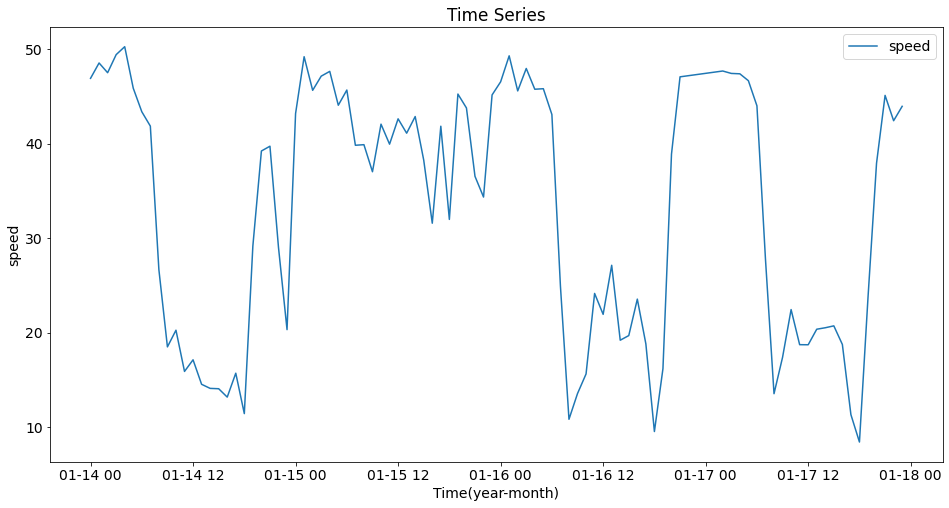

In [763]:
train.index = train.date # indexing the Datetime to get the time period on the x-axis.
df=train.drop('id',1)# drop ID variable to get only the Datetime on x-axis.
df = df[(df.year == 2017) & (df.month == 1) &(df.day.isin([14,15,16,17]))]
ts = df['speed']
plt.figure(figsize=(16,8))
plt.plot(ts, label='speed')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("speed")
plt.legend(loc='best')

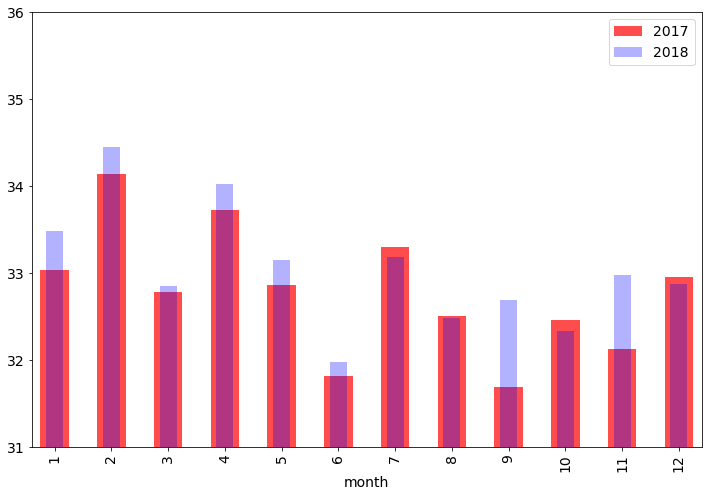

In [764]:
# 月份 - Speed
temp1 = train.groupby(['month'])['speed'].mean()
temp2 = train[(train.year == 2018)].groupby(['month'])['speed'].mean()

high = max(temp1.max(), temp2.max())
low = min(temp2.min(), temp2.min())
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.plot(title='Monthly Speed', fontsize=14, figsize=(10, 7))
temp1.plot.bar(color='r', alpha=.7, label='2017')
temp2.plot.bar(color='b', alpha=.3, label='2018', width=.3)
plt.legend()

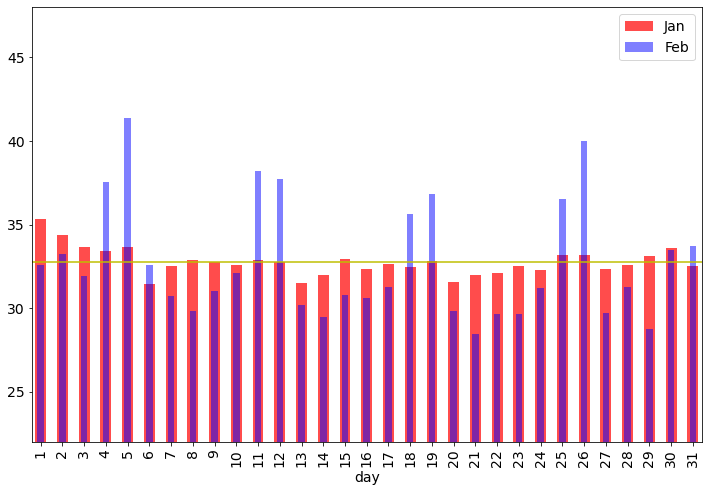

In [765]:
# 日期 - Speed
temp1 = train.groupby(['day'])['speed'].mean()
temp2 = train[(train.month == 3)].groupby(['day'])['speed'].mean()
high = max(temp1.max(), temp2.max())
low = min(temp1.min(), temp2.min())
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.plot(title='Daily Speed', fontsize=14, figsize=(30, 7))
temp1.plot.bar(color='r', alpha=.7, label='Jan')
temp2.plot.bar(color='b', alpha=.5, label='Feb', width=.3)
plt.axhline(y=temp1.mean(), color='y', linestyle='-')
plt.legend()

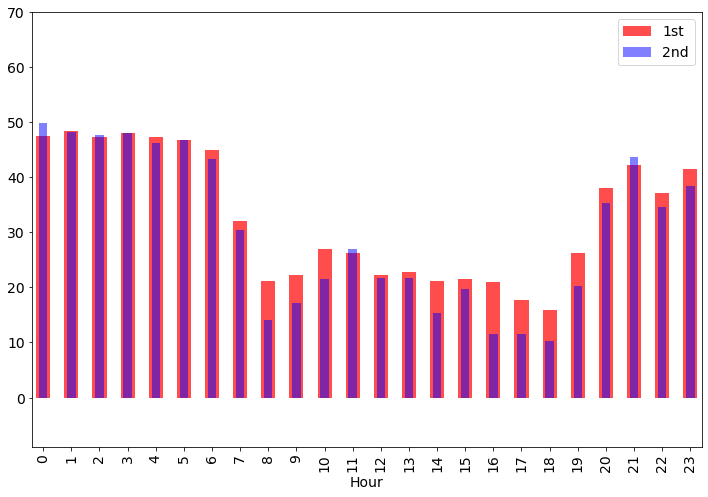

In [766]:
# 时间 - Speed
temp1 = train.groupby(['Hour'])['speed'].mean()
temp2 = train[(train.day == 25) & (train.month == 5)].groupby(['Hour'])['speed'].mean()
high = max(temp1.max(), temp2.max())
low = min(temp1.min(), temp2.min())
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.plot(title='Hour Speed', fontsize=14, figsize=(30, 7))
temp1.plot.bar(color='r', alpha=.7, label='1st')
temp2.plot.bar(color='b', alpha=.5, label='2nd', width=.3)
plt.legend()

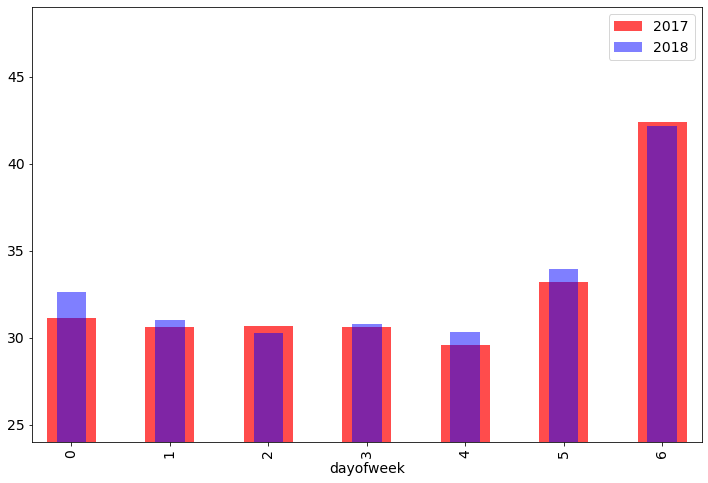

In [767]:
# 周几 - Speed
temp1 = train[(train.year == 2017)].groupby(['dayofweek'])['speed'].mean()
temp2 = train[(train.year == 2018)].groupby(['dayofweek'])['speed'].mean()
high = max(temp1.max(), temp2.max())
low = min(temp1.min(), temp2.min())
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.plot(title='Dayofweek Speed', fontsize=14, figsize=(30, 7))
temp1.plot.bar(color='r', alpha=.7, label='2017')
temp2.plot.bar(color='b', alpha=.5, label='2018', width=.3)
plt.legend()

holiday
False   32.55
True    34.84
Name: speed, dtype: float64

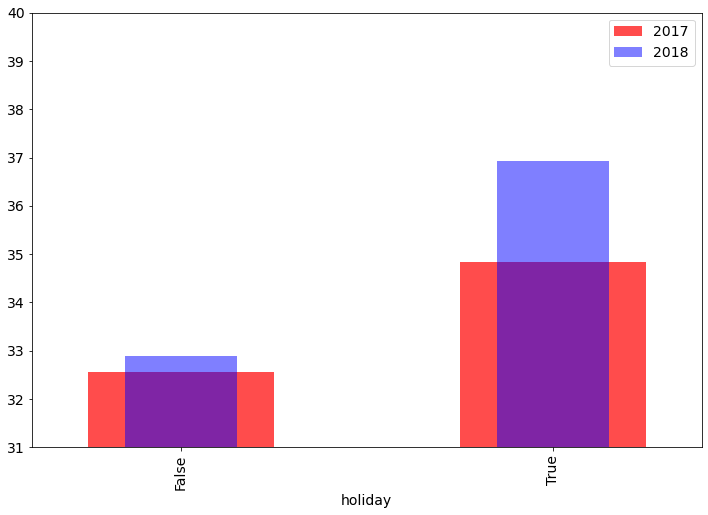

In [768]:
# 假期 - Speed
temp1 = train[(train.year == 2017)].groupby(['holiday'])['speed'].mean()
temp2 = train[(train.year == 2018)].groupby(['holiday'])['speed'].mean()
high = max(temp1.max(), temp2.max())
low = min(temp1.min(), temp2.min())
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.plot(title='Holiday Speed', fontsize=14, figsize=(30, 7))
temp1.plot.bar(color='r', alpha=.7, label='2017')
temp2.plot.bar(color='b', alpha=.5, label='2018', width=.3)
plt.legend()
temp1

In [769]:
# 处理不需要的特征
# drop_col = ['id', 'date', 'wind_size', 'wind_direction', 'weather', 'low', 'high']
# drop_col = ['id', 'date', 'Drizzle and Dangerously Windy', 'Drizzle and Windy', 'Heavy Rain and Dangerously Windy', 'Light Rain and Windy', 'Windy', 'Windy and Partly Cloudy',
#             'Drizzle and Humid', 'Humid', 'Humid and Overcast', 'Light Rain and Humid', 'Overcast', 'Possible Drizzle and Humid', 'Rain and Windy']
drop_col = ["around_holiday", "temperature", "apparentTemperature", "dewPoint",
            "humidity", "windSpeed", "windBearing", "visibility", "Clear",
            "Drizzle", "Drizzle and Dangerously Windy", "Drizzle and Humid",
            "Drizzle and Windy", "Heavy Rain", "Heavy Rain and Dangerously Windy",
            "Heavy Rain and Humid", "Heavy Rain and Windy", "Humid",
            "Humid and Overcast", "Humid and Partly Cloudy", "Light Rain",
            "Light Rain and Humid", "Light Rain and Windy", "Mostly Cloudy",
            "Overcast", "Partly Cloudy", "Possible Drizzle and Humid",
            "Rain and Humid", "Rain and Windy", "Windy", "Windy and Partly Cloudy",
            "season", "morning_peak", "evening_peak", "leisure_days", "leisure_month",
            "month1", "month3", "month5", "month10", "month11", "month12", "hour1",
            "hour2", "hour3", "hour4", "hour5", "hour6", "hour7", "hour8", "hour13",
            "hour14", "hour16", "hour17", "hour20", "hour21", "hour24", "day1",
            "day2", "day3", "day4", "day6", "day9", "day12", "day13", "day16", "day18",
            "day19", "day20", "day21", "day23", "day25", "day27", "day28", "day31", ]
drop_col += ['id', 'date']
x = train.drop(drop_col, 1)
x = x.dropna(axis=0,how='any')
y = x.speed
x = x.drop(['speed'], 1)
test_data = test.drop(drop_col, 1)

In [770]:
# 划分数据集
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=.87, random_state=20200929)
train_x.dtypes == test_x.dtypes

holiday                          True
uvIndex                          True
Foggy                            True
Humid and Foggy                  True
Humid and Mostly Cloudy          True
Possible Drizzle                 True
Possible Light Rain              True
Possible Light Rain and Humid    True
Rain                             True
Rain and Dangerously Windy       True
Windy and Humid                  True
year                             True
month                            True
day                              True
Hour                             True
afternoon                        True
dayofweek                        True
leisure_day                      True
month2                           True
month4                           True
month6                           True
month7                           True
month8                           True
month9                           True
hour9                            True
hour10                           True
hour11      

In [771]:
# stacking融合学习
# rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, criterion='mse')
# lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=.01,  max_depth=10, subsample=.95, num_leaves=512)
# xgb_model  = xgb.XGBRegressor(n_estimators=1650, learning_rate=.01, max_depth=10, subsample=.95)
# logic_model = LinearRegression()
# # 融合学习训练
# stack_model = StackingCVRegressor([rf_model, lgb_model, xgb_model], meta_regressor=logic_model, cv=5, store_train_meta_features=True)
# stack_model.fit(train_x, train_y)
# stack_pred = stack_model.predict(test_x.values)
# # 输出指标
# print(stack_model.score(test_x.values, test_y))
# stack_mse = mean_squared_error(test_y, stack_pred)
# print(f'MSE: {stack_mse}')

In [772]:
# 随机森林算法
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, criterion='mse')
rf_model.fit(train_x, train_y)
print(rf_model.score(test_x, test_y))
r_pred = rf_model.predict(test_x)
rf_mse = mean_squared_error(test_y, r_pred)
print(f'MSE: {rf_mse}')
# np.concatenate(([model.predict(test_x)], [test_y]), axis=0).T

0.923006015666566
MSE: 14.235839019641999


In [773]:
# lightgbm算法
l_model = lgb.LGBMRegressor(
    num_leaves=512,
    max_depth=10,
    learning_rate=.1,
    n_estimators=1000,
    subsample=.95)
l_model.fit(train_x, train_y)
print(l_model.score(test_x, test_y))
l_pred = l_model.predict(test_x)
r_mse = mean_squared_error(test_y, l_pred)
print(f'MSE: {r_mse}')

0.9307387074312612
MSE: 12.806099331486768


In [774]:
# 线性回归
line_model = LinearRegression()
line_model.fit(train_x, train_y)
print(line_model.score(test_x, test_y))
line_pred = line_model.predict(test_x)
line_mse = mean_squared_error(test_y, line_pred)
print(f'MSE: {line_mse}')

0.6506184676051895
MSE: 64.5990630913298


In [775]:
# xgBoost算法
x_model = xgb.XGBRegressor(n_estimators=1650, learning_rate=.01, max_depth=10, subsample=.95)
x_model.fit(train_x, train_y)
print(x_model.score(test_x, test_y))
x_pred = x_model.predict(test_x)
mse = mean_squared_error(test_y, x_pred)
print("MSE: %f" % (mse))

0.9391105556506526
MSE: 11.258183


In [776]:
# 计算特征相关性
feature_importance = x_model.feature_importances_


 [['holiday' 0.01708703488111496]
 ['uvIndex' 0.005335612688213587]
 ['Foggy' 0.007265190593898296]
 ['Humid and Foggy' 0.012327712960541248]
 ['Humid and Mostly Cloudy' 0.005579459015280008]
 ['Possible Drizzle' 0.0035827476531267166]
 ['Possible Light Rain' 0.007584992330521345]
 ['Possible Light Rain and Humid' 0.00450715608894825]
 ['Rain' 0.00534409424290061]
 ['Rain and Dangerously Windy' 0.007900223135948181]
 ['Windy and Humid' 0.0183792132884264]
 ['year' 0.004775054287165403]
 ['month' 0.006795859429985285]
 ['day' 0.008006330579519272]
 ['Hour' 0.29363611340522766]
 ['afternoon' 0.05954920873045921]
 ['dayofweek' 0.11834201961755753]
 ['leisure_day' 0.008644836023449898]
 ['month2' 0.015804611146450043]
 ['month4' 0.00974654033780098]
 ['month6' 0.007089909631758928]
 ['month7' 0.00912822037935257]
 ['month8' 0.006023325491696596]
 ['month9' 0.007359362207353115]
 ['hour9' 0.006269218400120735]
 ['hour10' 0.005103702656924725]
 ['hour11' 0.030244547873735428]
 ['hour12' 0.0

<AxesSubplot:xlabel='features'>

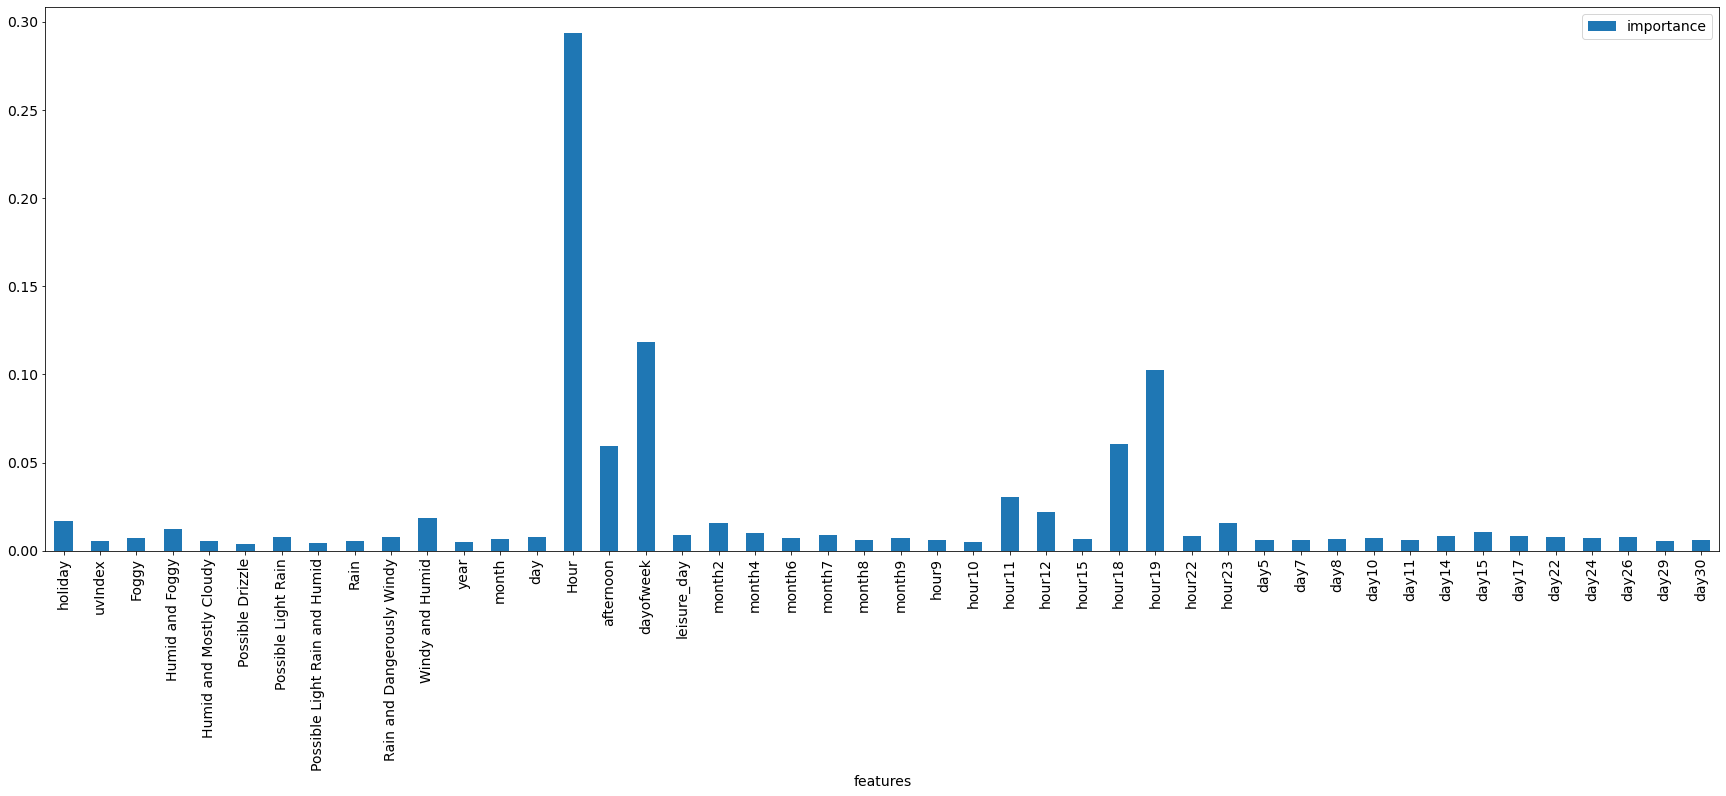

In [777]:
# 特征相关性图
features = np.concatenate((np.asarray([train_x.columns]).T, np.asarray([feature_importance]).T), axis=1)
[print(f'"{feature[0]}"', end=', ') for feature in features if feature[1] < .003]
print('\n', features)
features = pd.DataFrame(features, columns=['features', 'importance'])
features.index = features.features
features.plot.bar(figsize=(30, 10))

In [778]:
# 预测test写入文件
prediction = np.asarray([x_model.predict(test_data.values)]).T
df_predict = pd.DataFrame(prediction)
df_predict.index.name = 'id'
df_predict = df_predict.rename(columns={0: 'speed'})
df_predict.to_csv('predict.csv', header=True)
np.to_csv('predict.csv', prediction, delimiter=',')
